In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Data Augmentation-XrayImg

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Data Augmentation-XrayImg


In [ ]:
import torch
import glob
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt 
import cv2
from pycocotools.coco import COCO
import json
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
from tqdm.notebook import tqdm

In [ ]:
train_annotation_path='./XRAYBoneDataset/annotations/instances_train.json'
train_image_folder='./XRAYBoneDataset/train/'
train_mask_folder='./XRAYBoneDataset/train/mask'
train_export_data_path='./XRAYBoneDataset/data_train.json'


val_annotation_path='./XRAYBoneDataset/annotations/instances_val.json'
val_image_folder='./XRAYBoneDataset/val/'
val_mask_folder='./XRAYBoneDataset/val/mask'
val_export_data_path='./XRAYBoneDataset/data_val.json'


test_annotation_path='./XRAYBoneDataset/annotations/instances_test.json'
test_image_folder='./XRAYBoneDataset/test/'
test_mask_folder='./XRAYBoneDataset/test/mask'
test_export_data_path='./XRAYBoneDataset/data_test.json'


EPOCH_N=10
BATCH_SIZE=4
WORKER_N=2
DEVICE='cuda'

In [ ]:


def read_json(path):
    with open(path, "r") as File:
        data = json.load(File)
        return data

def export_coco_format_data(annotation_path='./XRAYBoneDataset/annotations/instances_train.json',
                            image_folder='./XRAYBoneDataset/train/',
                            mask_folder='./XRAYBoneDataset/train/mask',
                            export_data_path='./XRAYBoneDataset/data_train.json'):
    coco = COCO(annotation_path)
    anns_ids = coco.getAnnIds()
    anns = coco.loadAnns(anns_ids)

    img_info = coco.imgs
    # group all annotations have same image id
    groups = {}
    for ann in anns:
        image_id = ann['image_id']
        if image_id not in groups:
            groups[image_id] = [ann]
        else:
            groups[image_id].append(ann)

    # save mask in for each image
    image_label_pairs = {}
    for image_id, ann_list in groups.items():
        image_mask = None
        for ann in ann_list:
            if image_mask is None:
                image_mask = coco.annToMask(ann)
            else:
                image_mask += coco.annToMask(ann)
        #print(image_mask.shape)
        image_mask[image_mask > 1] = 1
        filename = img_info[image_id]['file_name']
        name, _ = os.path.splitext(filename)
        mask_path = os.path.join(mask_folder, name + '.png').replace('JPEGImages/','')
        cv2.imwrite(mask_path, image_mask)

        image_path = os.path.join(image_folder, filename)
        if not os.path.exists(image_path):
            raise ValueError('not found', image_path)
        image_label_pairs[image_path] =  mask_path

    with open(export_data_path, 'w') as f:
        json.dump(image_label_pairs, f)

In [ ]:
#export_coco_format_data(train_annotation_path,train_image_folder,train_mask_folder,train_export_data_path)
export_coco_format_data(val_annotation_path,val_image_folder,val_mask_folder,val_export_data_path)
export_coco_format_data(test_annotation_path,test_image_folder,test_mask_folder,test_export_data_path)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
mask_img_paths=glob.glob(os.path.join(train_mask_folder,'*.png'))

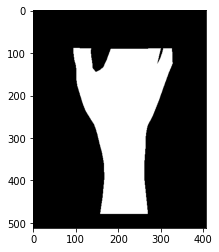

In [ ]:
img=cv2.imread(mask_img_paths[5])
img[img>0]=255
plt.imshow(img)
plt.show()

In [ ]:
class my_dataset(Dataset):

  def __init__(self,img_folder,mask_folder):
    self.img_paths=glob.glob(os.path.join(img_folder,'JPEGImages/*.jpg'))
    self.mask_paths=glob.glob(os.path.join(mask_folder,'*.png'))
    self.preprocess = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Resize((300,300)),           
                      #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                      ])


  def get(self,paths,idx):
    img_path=paths[idx]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=self.preprocess(img)
    #img=img.permute(2,1,0)
    return img


  def __getitem__(self,idx):
    img=self.get(self.img_paths,idx)
    mask=self.get(self.mask_paths,idx)
    return img,mask

  def __len__(self):
    return len(self.img_paths)

In [ ]:
train_dataset=my_dataset(train_image_folder,train_mask_folder)
val_dataset=my_dataset(val_image_folder,val_mask_folder)
test_dataset=my_dataset(test_image_folder,test_mask_folder)

train_dataloader = torch.utils.data.DataLoader(
   train_dataset,
   batch_size=BATCH_SIZE,
   num_workers=WORKER_N,
   shuffle=True,
   )

val_dataloader = torch.utils.data.DataLoader(
   val_dataset,
   batch_size=BATCH_SIZE,
   num_workers=WORKER_N,
   shuffle=True,
   )

test_dataloader = torch.utils.data.DataLoader(
   test_dataset,
   batch_size=BATCH_SIZE,
   num_workers=WORKER_N,
   shuffle=False,
   )

In [ ]:
print(test_dataset[0][1].shape)

torch.Size([3, 300, 300])


In [ ]:
def createDeepLabv3(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    return model

model=createDeepLabv3()
model.to(DEVICE)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
best_point=9999
criterion = torch.nn.MSELoss(reduction='mean')
optimizer=torch.optim.Adam(model.parameters(), lr=3e-4)
for epoch in range(EPOCH_N):
  print("Training...")
  train_loss=0
  val_loss=0
  for imgs,masks in tqdm(train_dataloader):
    model.train()
    optimizer.zero_grad()
    imgs=imgs.to(DEVICE)
    masks=masks.to(DEVICE)
    outs=model(imgs)
    loss=criterion(outs['out'],masks)  	
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()

  for imgs,masks in tqdm(val_dataloader):
    model.eval()
    imgs=imgs.to(DEVICE)
    masks=masks.to(DEVICE)
    outs=model(masks)
    loss=model(outs['out'],masks)
    val_loss+=loss.item()
    if loss.item()<best_point:
      best_point=loss.item()
      torch.save(model.state_dict(), "./best_val.pth")
  print("------------------------->", train_loss,val_loss)

Training...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4, 3, 300, 300])) that is different to the input size (torch.Size([4, 1, 300, 300])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([3, 3, 300, 300])) that is different to the input size (torch.Size([3, 1, 300, 300])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


TypeError: ignored